In [157]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import dynamiqs as dq
import jax.numpy as jnp
from scipy.interpolate import RegularGridInterpolator
import cvxpy as cp
from scipy.linalg import sqrtm
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

## Useful function

In [136]:
def wigner_fct(x, y, data):
    xvec, yvec, W = data

    # # Ensure inputs are NumPy arrays
    # xvec = np.asarray(xvec)
    # yvec = np.asarray(yvec)
    # W = np.asarray(W)

    # # Create interpolator (lazy init is better in practice but kept inline here)
    # interp = RegularGridInterpolator((xvec, yvec), W.T)

    # # Interpolation expects array of shape (N, 2)
    # point = np.array([[x, y]])

    # return float(interp(point))  # Return scalar
    i = np.where(np.isclose(xvec, x))[0]
    j = np.where(np.isclose(yvec, y))[0]

    if len(i) == 0 or len(j) == 0:
        raise ValueError(f"Point (x={x}, y={y}) not found in grid.")

    return W[i[0], j[0]]

def pk(x, y, data):
    return 1/2 * (1 + np.pi/2 * wigner_fct(x, y, data))  # Return scalar

def measurement_operator(alpha, dim, original_dim=None):
    """
    Construct E_alpha for a given displacement alpha.

    If original_dim is provided, returns truncated operator of shape (original_dim, original_dim).
    """
    D = dq.displace(dim, alpha)
    P = dq.parity(dim)
    E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))

    if original_dim is not None and original_dim < dim:
        E = E.data  # unwrap before slicing
        E = E[:original_dim, :original_dim]
    else:
        E = E.data  # always unwrap for CVXPY use
    return E


In [137]:
def loss_cvxpy(rho_tilde, X, Y, data, dim, original_dim=None):
    alpha_k = (X + 1j * Y).ravel()
    points = np.stack([X.ravel(), Y.ravel()], axis=-1)
    target_p_k = np.array([pk(x, y, data) for x, y in points])

    pred_p_k = []
    for alpha in alpha_k:
        E = measurement_operator(alpha, dim, original_dim=original_dim)
        p = cp.real(cp.trace(E @ rho_tilde))
        pred_p_k.append(p)

    pred_p_k = cp.vstack(pred_p_k)
    target_p_k = target_p_k.reshape(-1, 1)

    return cp.sum_squares(pred_p_k - target_p_k) 

def fidelity(rho, rho_tilde):
    sqrt_rho = sqrtm(rho)
    inner = sqrt_rho @ rho_tilde @ sqrt_rho
    sqrt_inner = sqrtm(inner)
    return np.real(np.trace(sqrt_inner))**2


## Generate quantum state, density matrix and W

In [ ]:
def add_noise(W, sigma):
    """
    Add Gaussian noise to the Wigner function.
    """
    noise = np.random.normal(0, sigma, W.shape)
    W_noisy = W + noise
    return W_noisy

def generate_psi(dim, N, state_type, params, noise=False, sigma=1):
    
    x = jnp.linspace(-3, 3, N)
    p = jnp.linspace(-3, 3, N)
    
    if state_type == 'fock':
        n = params
        psi = dq.fock(dim, n)
        rho_true = dq.fock_dm(dim, n)
        x, y, W = dq.wigner(psi, xvec=x, yvec=p)
        if noise:
            W = add_noise(W, sigma)
        data = (x, y, W)
        plt.contourf(x, y, W, levels=100, cmap="RdBu_r")
        plt.colorbar()
        plt.xlabel("x")
        plt.ylabel("p")
        plt.title("Wigner function for fock state")
        plt.show()
        return psi, rho_true, data
    
    if state_type == 'coherent':
        alpha = params
        psi = dq.coherent(dim, alpha)
        rho_true = dq.coherent_dm(dim, alpha)
        x, y, W = dq.wigner(psi, xvec=x, yvec=p)
        if noise:
            W = add_noise(W, sigma) 
        data = (x, y, W)
        plt.contourf(x, y, W, levels=100, cmap="RdBu_r")
        plt.colorbar()
        plt.xlabel("x")
        plt.ylabel("p")
        plt.title("Wigner function for Coherent state")
        plt.show()
        
        return psi, rho_true, data
        
    if state_type[0] == 'cat':
        alpha = params
        rho_alpha = dq.coherent_dm(dim, alpha)
        rho_minus_alpha = dq.coherent_dm(dim, -alpha)

        # Create kets for |α⟩ and |−α⟩
        ket_alpha = dq.coherent(dim, alpha)
        ket_minus_alpha = dq.coherent(dim, -alpha)
        overlap = dq.braket(ket_minus_alpha, ket_alpha)
        
        if state_type[1] == 'even':
            psi_even =  np.sqrt(2)**(-1) * (ket_alpha + ket_minus_alpha)
            rho_cat_even = (rho_alpha + rho_minus_alpha +
                ket_alpha @ ket_minus_alpha.dag() +
                ket_minus_alpha @ ket_alpha.dag())

            rho_cat_even /= (2 * (1 + overlap.real))
            
            x, y, W = dq.wigner(psi_even, xvec=x, yvec=p)
            if noise:
                W = add_noise(W, sigma)
            data = (x, y, W)
            plt.contourf(x, y, W, levels=100, cmap="RdBu_r")
            plt.colorbar()
            plt.xlabel("x")
            plt.ylabel("p")
            plt.title("Wigner function for even cat state")
            plt.show()
            
            return psi_even, rho_cat_even, data
        
        elif state_type[1] == 'odd':
            psi_odd = np.sqrt(2)**(-1) * (ket_alpha - ket_minus_alpha)
            rho_cat_odd = (rho_alpha + rho_minus_alpha -
               ket_alpha @ ket_minus_alpha.dag() -
               ket_minus_alpha @ ket_alpha.dag())
            rho_cat_odd /= (2 * (1 - overlap.real))
        
            x, y, W = dq.wigner(psi_odd, xvec=x, yvec=p)
            if noise:
                W = add_noise(W, sigma)
            data = (x, y, W)
            plt.contourf(x, y, W, levels=100, cmap="RdBu_r")
            plt.colorbar()
            plt.xlabel("x")
            plt.ylabel("p")
            plt.title("Wigner function for odd cat state")
            plt.show()
            
            return psi_odd, rho_cat_odd, data


### Fit the density matrix

We have chosen to work in a fock space of 10, with deflation between -3, 3, 30 linearly spaced points, and an extra dimension of 40. If we increase the number of points to 50, almost everything will go to 99% fidelity. We kept it like this to be able to see the differences.

In [147]:
def fit_dm(data, rho_true, N, dim_ext, dim=10):
    
    # Choose displacement points
    xmin, xmax = -3, 3
    ymin, ymax = -3, 3

    # Number of points per axis
    #N = 50

    # Generate grid of (x, y) values
    x_vals = np.linspace(xmin, xmax, N)
    y_vals = np.linspace(ymin, ymax, N)

    # Create 2D grid of x and y values
    X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

    rho = cp.Variable((dim, dim), complex=True)
    #rho = 0.5 * (rho + rho.H)

    constraints = [
        rho >> 0,
        cp.trace(rho) == 1,
        rho == rho.H
    ]

    loss_expr = loss_cvxpy(rho, X, Y, data, dim=dim_ext, original_dim=dim)
    problem = cp.Problem(cp.Minimize(loss_expr), constraints)
    problem.solve(solver=cp.SCS)

    print("Optimal value:", problem.value)
    
    print("Fidelity:", fidelity(rho_true, rho.value))

    diag_true = np.real(np.diag(rho_true))
    diag_reco = np.real(np.diag(rho.value))

    # Print
    print("True diag:        ", np.round(diag_true, 5))
    print("Reconstructed diag:", np.round(diag_reco, 5))
    
    return fidelity(rho_true, rho.value)

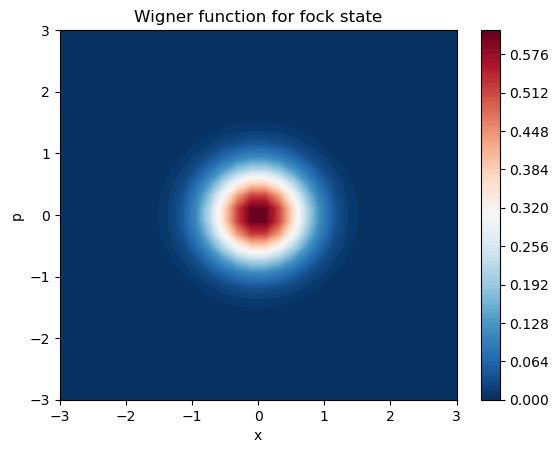

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 4.081745149644388e-08
Fidelity: 0.999915630534781
True diag:         [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [9.9992e-01 2.0000e-05 1.0000e-05 1.0000e-05 1.0000e-05 1.0000e-05
 1.0000e-05 1.0000e-05 0.0000e+00 1.0000e-05]


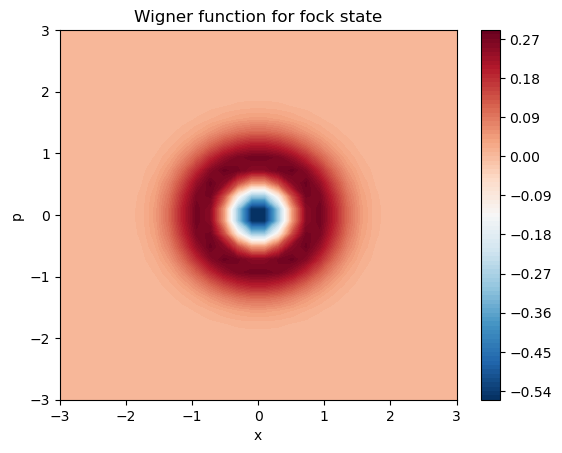

Optimal value: 1.165450425583306e-06
Fidelity: 0.9999403214271091
True diag:         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [ 1.0000e-05  9.9994e-01  1.0000e-05  1.0000e-05  0.0000e+00 -0.0000e+00
 -0.0000e+00  3.0000e-05  1.0000e-05  0.0000e+00]


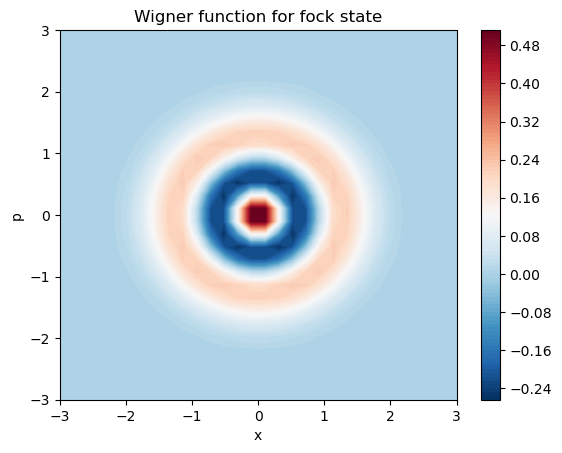

Optimal value: 0.00014374849383598731
Fidelity: 0.9993037348450332
True diag:         [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [-0.000e+00 -2.000e-05  9.993e-01  1.900e-04  6.000e-05 -1.000e-05
 -1.000e-05  3.300e-04  1.600e-04 -1.000e-05]


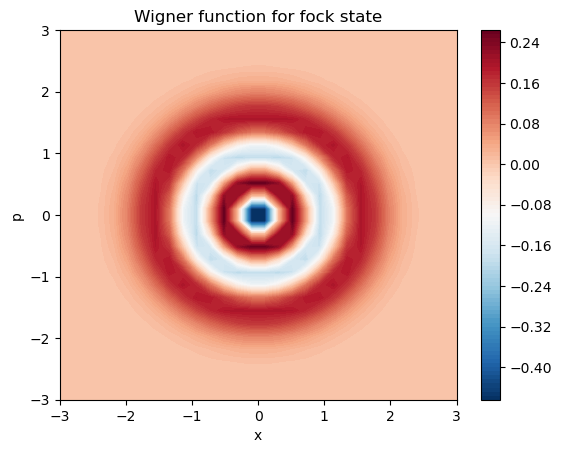

Optimal value: 0.004834335967507637
Fidelity: 0.9964079577624234
True diag:         [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Reconstructed diag: [7.0000e-05 2.8000e-04 0.0000e+00 9.9641e-01 8.3000e-04 1.0000e-05
 0.0000e+00 6.0000e-05 2.2000e-03 1.4000e-04]


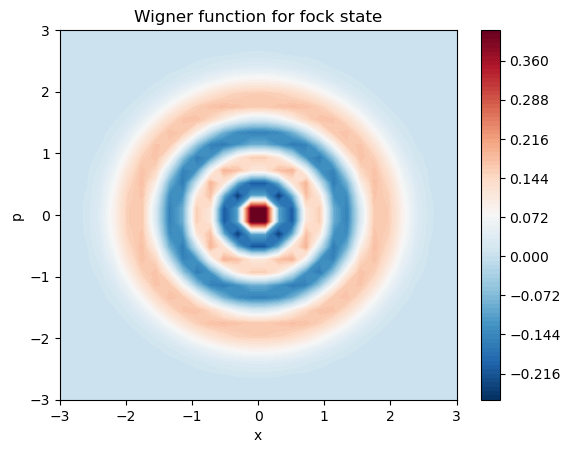

Optimal value: 0.056364738576892254
Fidelity: 0.9802299261416199
True diag:         [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Reconstructed diag: [ 2.2000e-04  2.0600e-03  0.0000e+00  6.1500e-03  9.8023e-01  0.0000e+00
 -0.0000e+00  8.1500e-03  1.9900e-03  1.2000e-03]


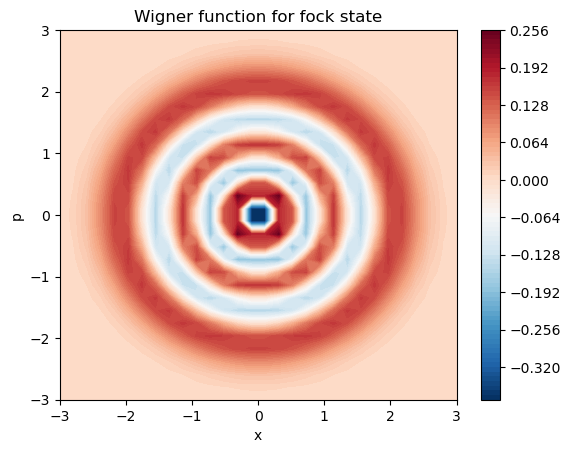

Optimal value: 0.2436813223093272
Fidelity: 0.9302515586545446
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [ 3.2000e-04  4.7100e-03  0.0000e+00  1.0750e-02  1.4210e-02  9.3025e-01
 -0.0000e+00  8.7200e-03  2.6880e-02  4.1800e-03]


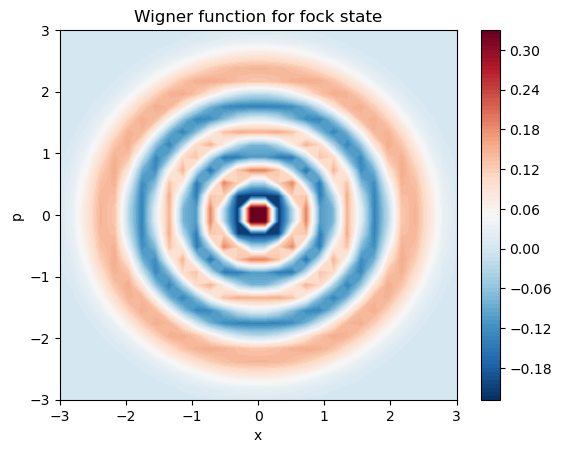

Optimal value: 0.44074251164891626
Fidelity: 0.8883140407568499
True diag:         [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Reconstructed diag: [1.3000e-04 4.0300e-03 2.8000e-04 2.9700e-03 2.6090e-02 1.4160e-02
 8.8831e-01 7.3000e-04 2.7570e-02 3.5720e-02]


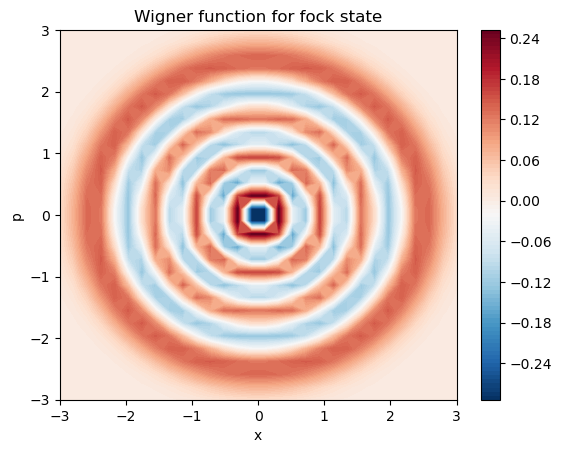

Optimal value: 0.630586003376925
Fidelity: 0.864279334961488
True diag:         [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Reconstructed diag: [1.3000e-04 1.5000e-04 4.2000e-04 1.2700e-03 2.1540e-02 5.0910e-02
 0.0000e+00 8.6428e-01 4.1700e-03 5.7120e-02]


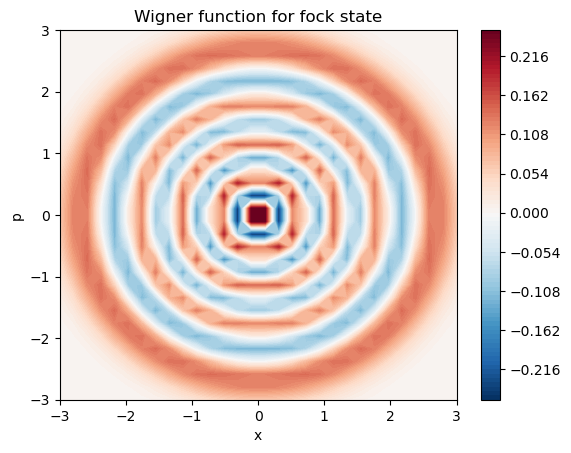

Optimal value: 0.9066475221549526
Fidelity: 0.8301974698359984
True diag:         [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Reconstructed diag: [1.825e-02 1.863e-02 1.846e-02 2.090e-02 2.470e-02 5.142e-02 6.840e-03
 2.700e-04 8.302e-01 1.033e-02]


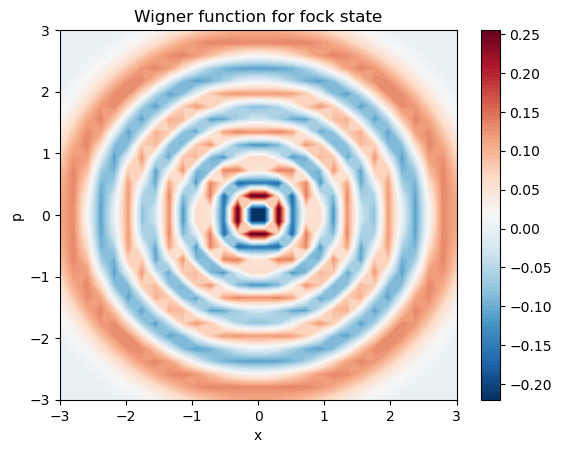

Optimal value: 1.2291376685764415
Fidelity: 0.8141516643407664
True diag:         [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Reconstructed diag: [2.3700e-02 2.3620e-02 2.3210e-02 2.1230e-02 1.7400e-02 1.8200e-02
 3.4270e-02 2.4160e-02 8.0000e-05 8.1415e-01]


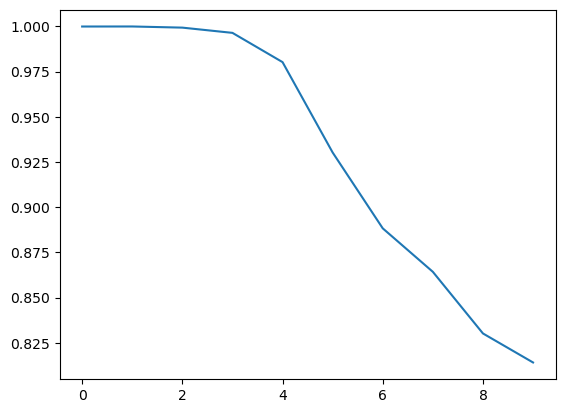

In [149]:
fidelities_fock = []
N = 30
dim = 40

for i in range(10):
    psi, rho_true, data = generate_psi(10, N, 'fock', i)
    fidelity_fock = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_fock.append(fidelity_fock)
    
plt.plot([i for i in range(10)], fidelities_fock, label='Fock state')

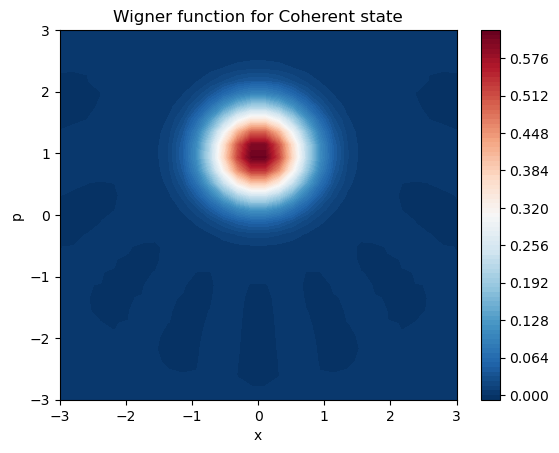

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 1.8012488409433837e-05
Fidelity: 0.9997819539135355
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [ 3.6780e-01  3.6781e-01  1.8389e-01  6.1340e-02  1.5350e-02  3.0600e-03
  5.1000e-04  1.5000e-04  1.0000e-04 -1.0000e-05]


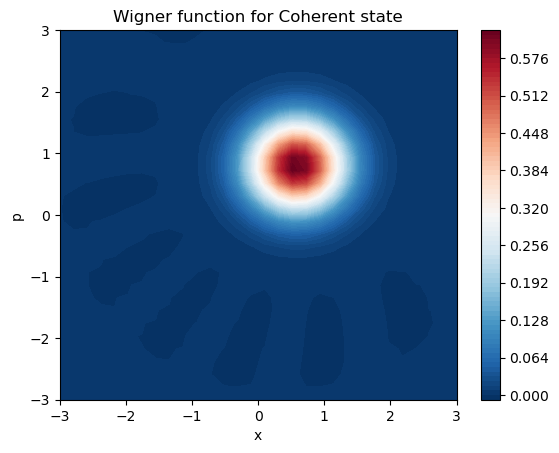

Optimal value: 0.0015736078064840515
Fidelity: 0.9975359171261283
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6735e-01 3.6719e-01 1.8357e-01 6.1410e-02 1.5490e-02 2.9900e-03
 5.8000e-04 5.9000e-04 5.7000e-04 2.5000e-04]


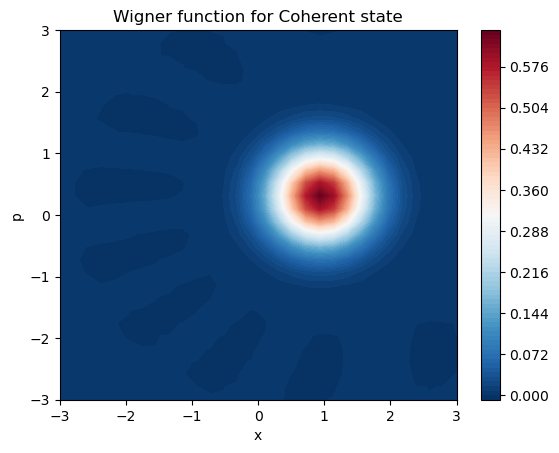

Optimal value: 0.00028229502293568694
Fidelity: 0.998964830370565
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6760e-01 3.6756e-01 1.8379e-01 6.1370e-02 1.5410e-02 3.0500e-03
 5.6000e-04 3.0000e-04 2.5000e-04 1.1000e-04]


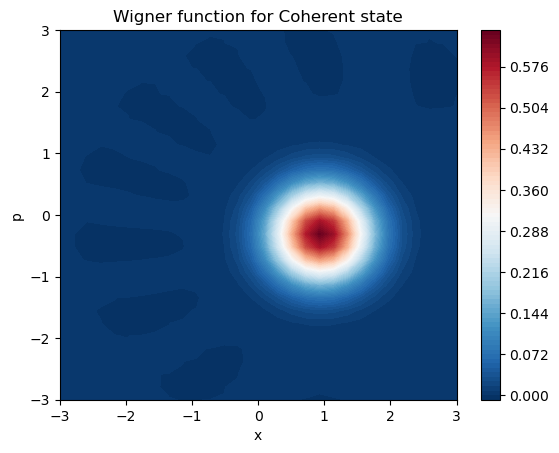

Optimal value: 0.00028229470816126334
Fidelity: 0.998964822681064
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6760e-01 3.6756e-01 1.8379e-01 6.1370e-02 1.5410e-02 3.0500e-03
 5.6000e-04 3.0000e-04 2.5000e-04 1.1000e-04]


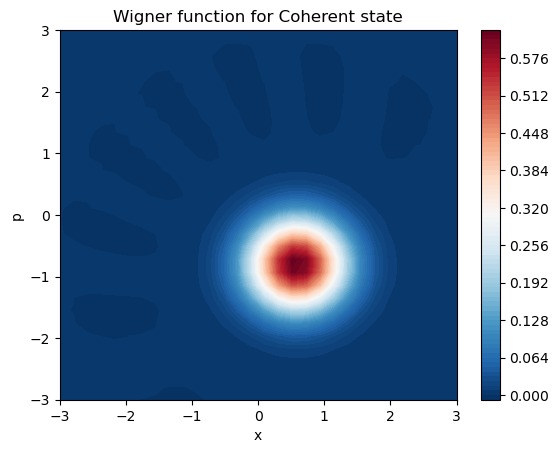

Optimal value: 0.001573606552067842
Fidelity: 0.9975359126190925
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6735e-01 3.6719e-01 1.8357e-01 6.1410e-02 1.5490e-02 2.9900e-03
 5.8000e-04 5.9000e-04 5.7000e-04 2.5000e-04]


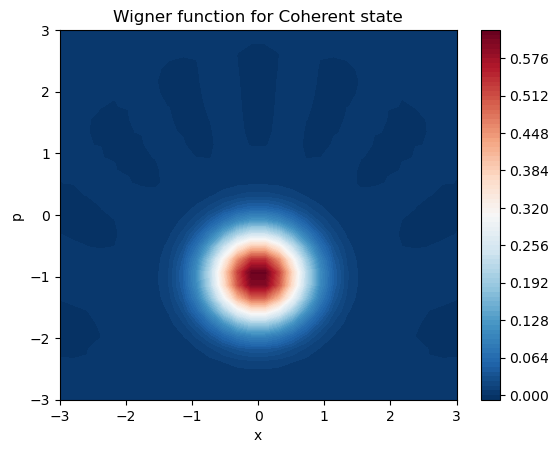

Optimal value: 1.801246767567008e-05
Fidelity: 0.9997819649491345
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [ 3.6780e-01  3.6781e-01  1.8389e-01  6.1340e-02  1.5350e-02  3.0600e-03
  5.1000e-04  1.5000e-04  1.0000e-04 -1.0000e-05]


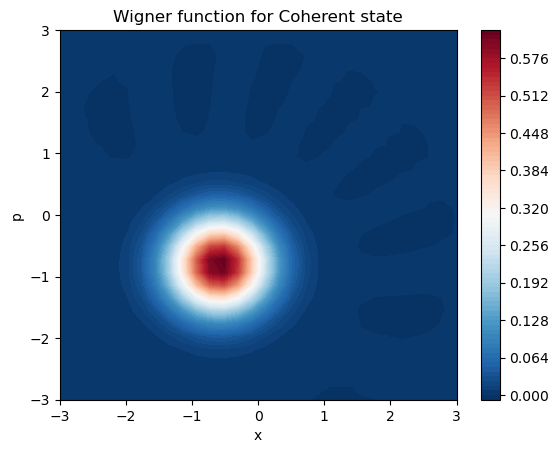

Optimal value: 0.0015736074308404218
Fidelity: 0.9975359308435541
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6735e-01 3.6719e-01 1.8357e-01 6.1410e-02 1.5490e-02 2.9900e-03
 5.8000e-04 5.9000e-04 5.7000e-04 2.5000e-04]


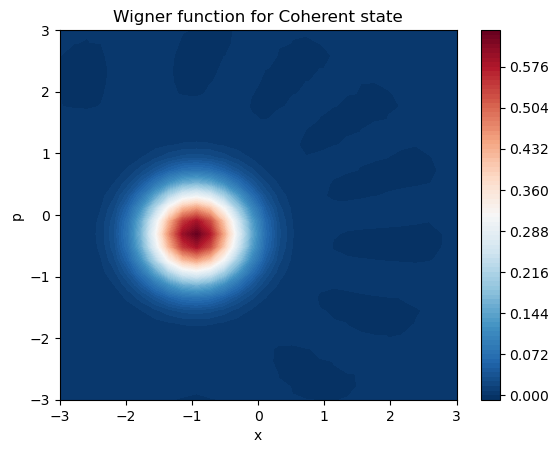

Optimal value: 0.00028229500692438533
Fidelity: 0.9989648393944911
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6760e-01 3.6756e-01 1.8379e-01 6.1370e-02 1.5410e-02 3.0500e-03
 5.6000e-04 3.0000e-04 2.5000e-04 1.1000e-04]


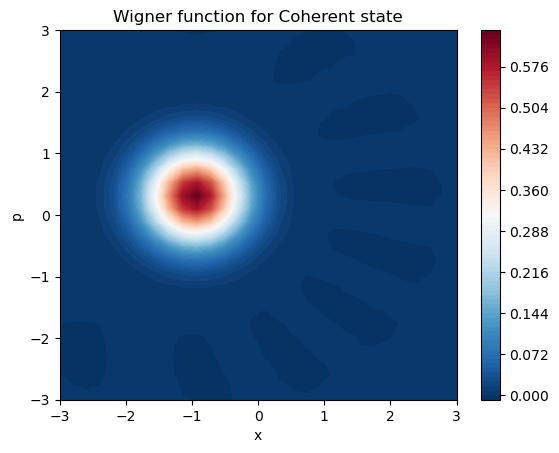

Optimal value: 0.0002822953938217843
Fidelity: 0.998964834276485
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6760e-01 3.6756e-01 1.8379e-01 6.1370e-02 1.5410e-02 3.0500e-03
 5.6000e-04 3.0000e-04 2.5000e-04 1.1000e-04]


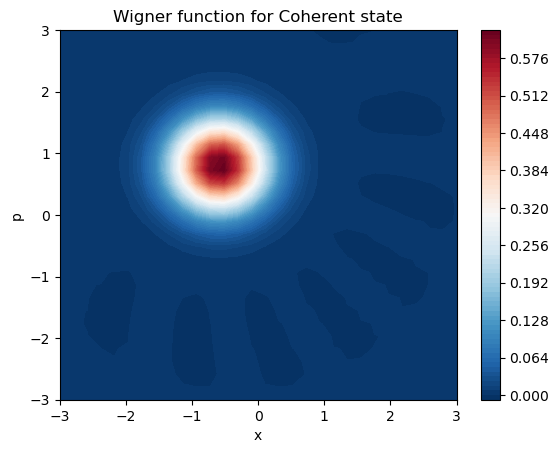

Optimal value: 0.0015736066465068957
Fidelity: 0.9975359142711255
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6735e-01 3.6719e-01 1.8357e-01 6.1410e-02 1.5490e-02 2.9900e-03
 5.8000e-04 5.9000e-04 5.7000e-04 2.5000e-04]


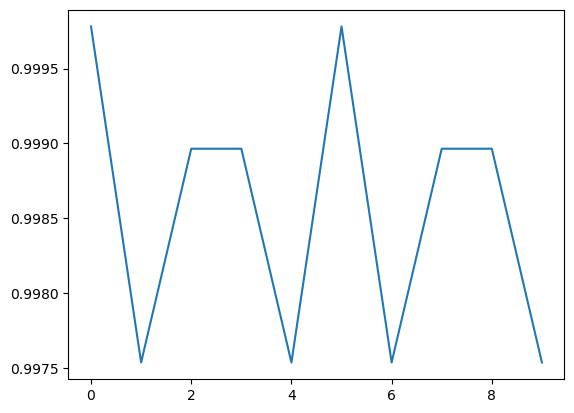

In [154]:
fidelities_coherent = []

n = 10
alphas = [np.exp(2j * np.pi * k / n) for k in range(n)]

for alpha in alphas:
    psi, rho_true, data = generate_psi(10, N, 'coherent', alpha)
    fidelity_coherent = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_coherent.append(fidelity_coherent)
    
plt.plot([i for i in range(n)], fidelities_coherent, label='Coherent state')

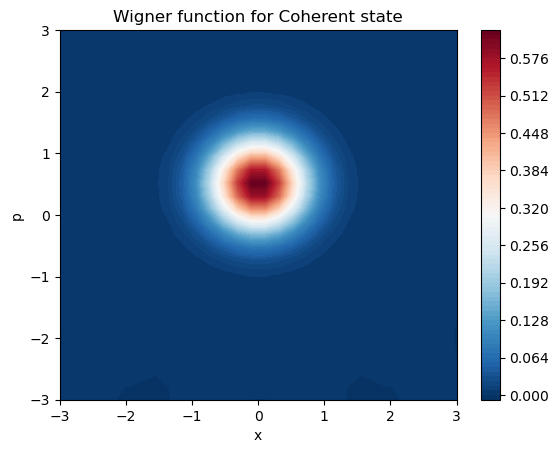

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 4.31303099520524e-07
Fidelity: 0.9999294244712559
True diag:         [7.788e-01 1.947e-01 2.434e-02 2.030e-03 1.300e-04 1.000e-05 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]
Reconstructed diag: [7.7875e-01 1.9470e-01 2.4350e-02 2.0400e-03 1.3000e-04 1.0000e-05
 0.0000e+00 1.0000e-05 1.0000e-05 1.0000e-05]


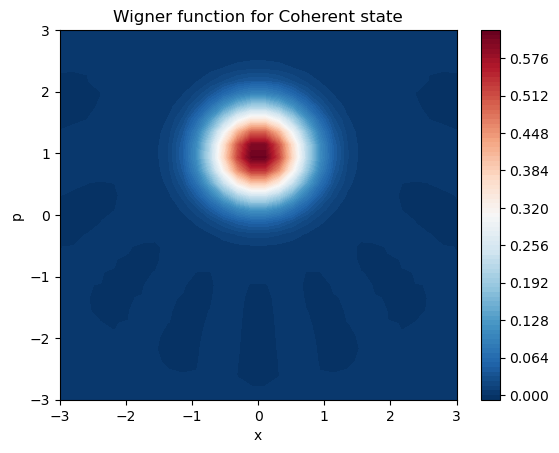

Optimal value: 1.8012488409433837e-05
Fidelity: 0.9997819539135355
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [ 3.6780e-01  3.6781e-01  1.8389e-01  6.1340e-02  1.5350e-02  3.0600e-03
  5.1000e-04  1.5000e-04  1.0000e-04 -1.0000e-05]


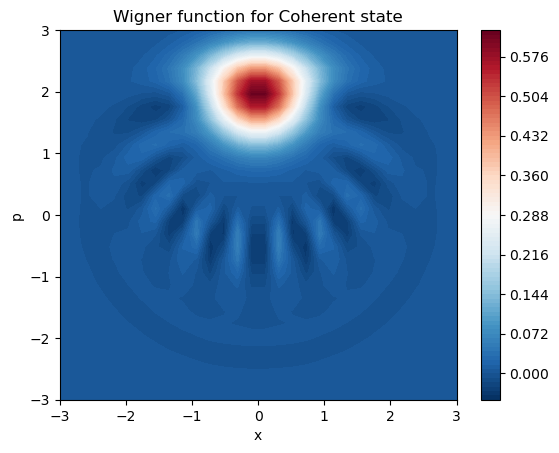

Optimal value: 0.010552903240338191
Fidelity: 0.9934692187139903
True diag:         [0.01832 0.07327 0.1465  0.1955  0.19486 0.15774 0.10101 0.06541 0.02199
 0.02541]
Reconstructed diag: [0.01831 0.0733  0.14648 0.19486 0.19399 0.15862 0.10445 0.06647 0.01975
 0.02377]


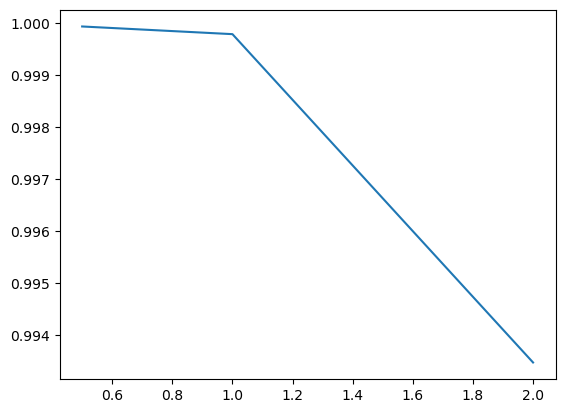

In [ ]:
fidelities_coherent_length = []
alphas = [0.5, 1, 1.5, 2]

for alpha in alphas:
    psi, rho_true, data = generate_psi(10, N, 'coherent', alpha)
    fidelity_coherent = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_coherent_length.append(fidelity_coherent)
    
plt.plot(alphas, fidelities_coherent_length, label='Coherent state')

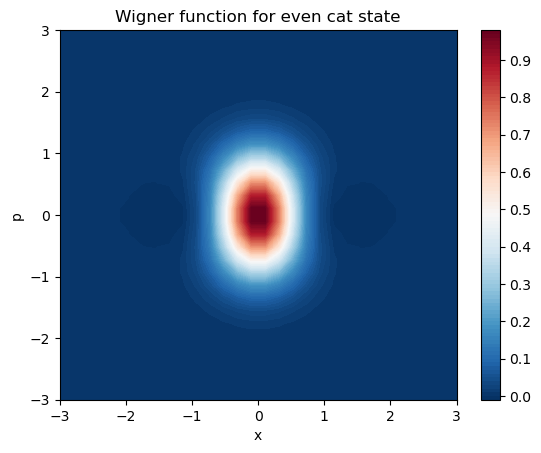

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 1.6874421212422295
Fidelity: 1.0000000324077345
True diag:         [9.6954e-01 0.0000e+00 3.0300e-02 0.0000e+00 1.6000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
Reconstructed diag: [ 9.6954e-01  0.0000e+00  3.0300e-02  0.0000e+00  1.6000e-04 -0.0000e+00
 -1.0000e-05 -1.0000e-05 -0.0000e+00  1.0000e-05]


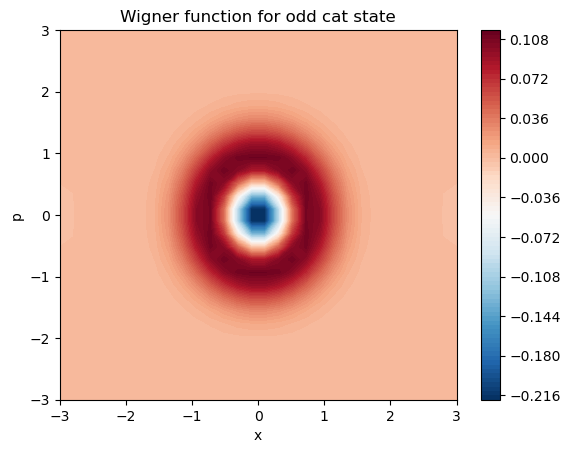

Optimal value: 0.1877819619653172
Fidelity: 0.46095287374934363
True diag:         [0.0000e+00 9.8966e-01 0.0000e+00 1.0310e-02 0.0000e+00 3.0000e-05
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
Reconstructed diag: [0.06749 0.45688 0.06736 0.07074 0.06442 0.0602  0.056   0.05269 0.04874
 0.0555 ]


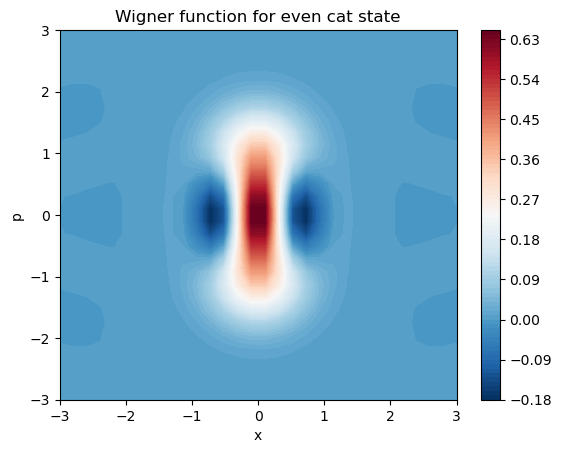

Optimal value: 0.08401743208437909
Fidelity: 1.0000023374469573
True diag:         [6.4805e-01 0.0000e+00 3.2403e-01 0.0000e+00 2.7000e-02 0.0000e+00
 9.0000e-04 0.0000e+00 2.0000e-05 0.0000e+00]
Reconstructed diag: [ 6.4806e-01 -0.0000e+00  3.2403e-01 -0.0000e+00  2.6990e-02 -1.0000e-05
  9.0000e-04  1.0000e-05  2.0000e-05  2.0000e-05]


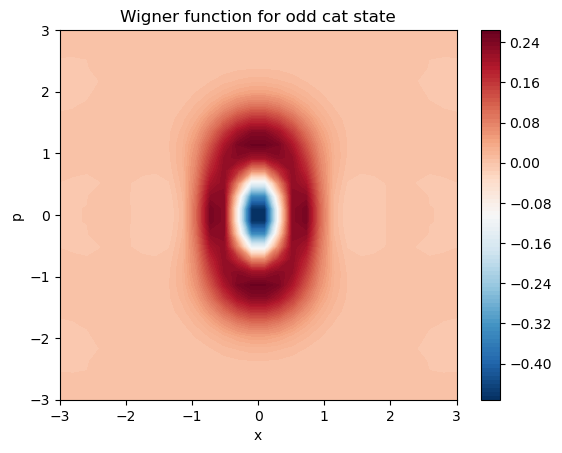

Optimal value: 0.009426200634762644
Fidelity: 0.8797932101452622
True diag:         [0.0000e+00 8.5092e-01 0.0000e+00 1.4182e-01 0.0000e+00 7.0900e-03
 0.0000e+00 1.7000e-04 0.0000e+00 0.0000e+00]
Reconstructed diag: [0.01512 0.75087 0.01508 0.13752 0.0143  0.01938 0.01238 0.01202 0.01098
 0.01233]


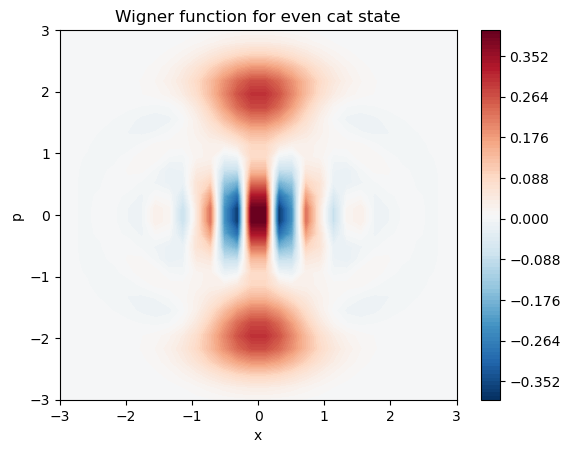

Optimal value: 0.005983569849600342
Fidelity: 0.9679673285991661
True diag:         [0.03795 0.      0.30352 0.      0.40371 0.      0.20927 0.      0.04555
 0.     ]
Reconstructed diag: [0.04049 0.00395 0.29727 0.00458 0.39489 0.00698 0.20711 0.00076 0.04255
 0.00143]


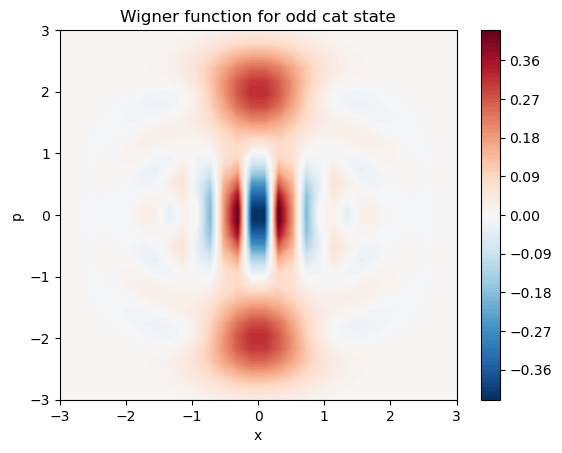

Optimal value: 0.019740174129692985
Fidelity: 0.9998818016869403
True diag:         [0.      0.14162 0.      0.3779  0.      0.30492 0.      0.12643 0.
 0.04913]
Reconstructed diag: [-0.       0.14243 -0.       0.37859 -0.       0.30556 -0.       0.12895
 -0.       0.04448]


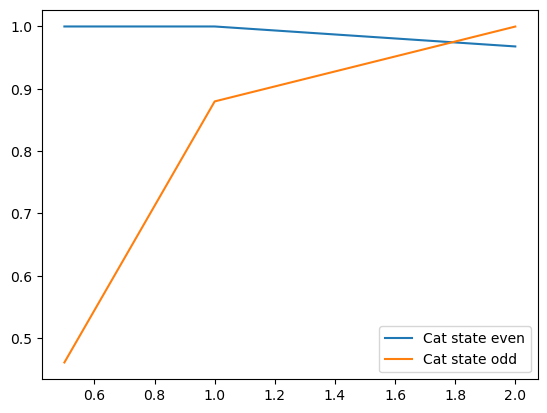

In [167]:
fidelities_cat_even = []
fidelities_cat_odd = []

for alpha in alphas:
    psi, rho_true, data = generate_psi(10, N, ('cat', 'even'), alpha)
    fidelity_cat_even = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_cat_even.append(fidelity_cat_even)

    psi, rho_true, data = generate_psi(10, N, ('cat', 'odd'), alpha)
    fidelity_cat_odd = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_cat_odd.append(fidelity_cat_odd)
    
    
plt.plot(alphas, fidelities_cat_even, label='Cat state even')
plt.plot(alphas, fidelities_cat_odd, label='Cat state odd') 
plt.legend()
plt.show()

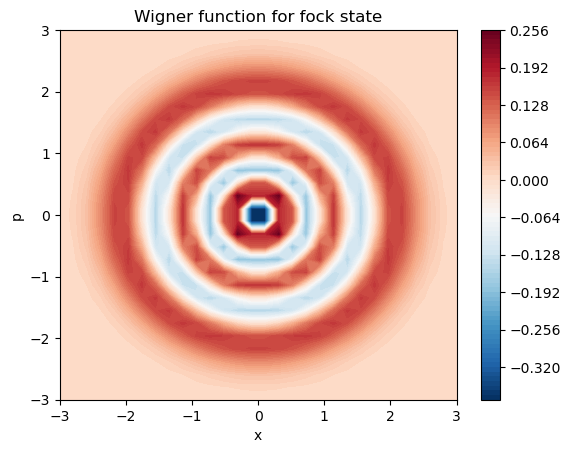

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1537180879.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 0.2436813223093272
Fidelity: 0.9302515586545446
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [ 3.2000e-04  4.7100e-03  0.0000e+00  1.0750e-02  1.4210e-02  9.3025e-01
 -0.0000e+00  8.7200e-03  2.6880e-02  4.1800e-03]


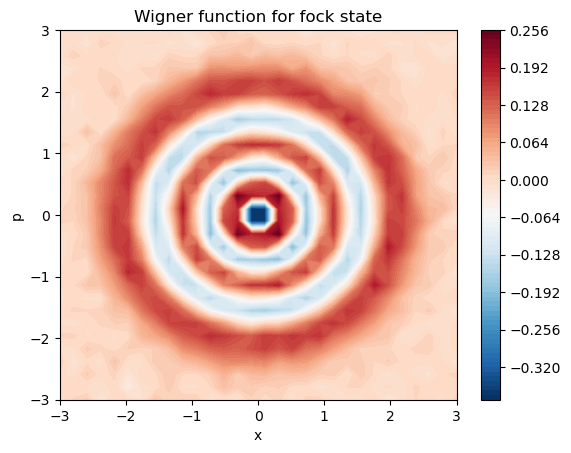

Optimal value: 0.2932643443128201
Fidelity: 0.92678071381453
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [6.0000e-04 5.8800e-03 4.1000e-04 1.0780e-02 1.3400e-02 9.2678e-01
 1.7000e-04 1.0230e-02 2.5220e-02 6.5200e-03]


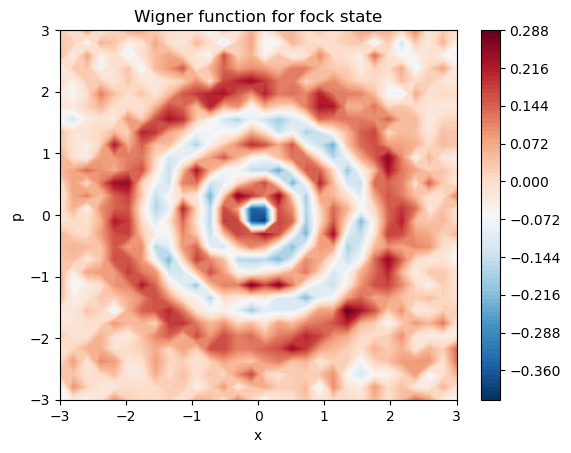

Optimal value: 1.4677115830114953
Fidelity: 0.8838184329867311
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.00629 0.00535 0.00619 0.02208 0.03077 0.88382 0.00118 0.00219 0.02637
 0.01575]


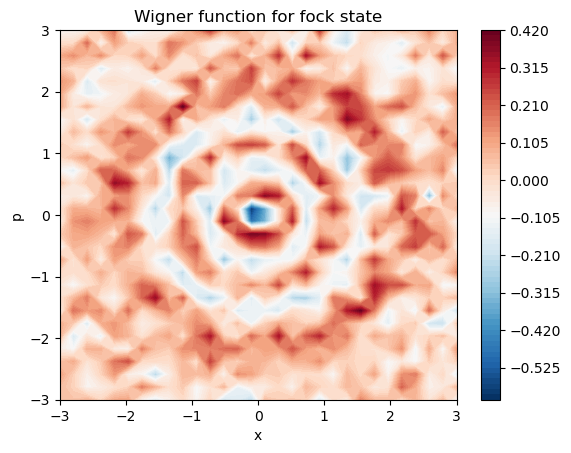

Optimal value: 5.677565714003787
Fidelity: 0.8849234635844706
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.01019 0.02756 0.00477 0.01434 0.00706 0.88492 0.00328 0.00608 0.03266
 0.00913]


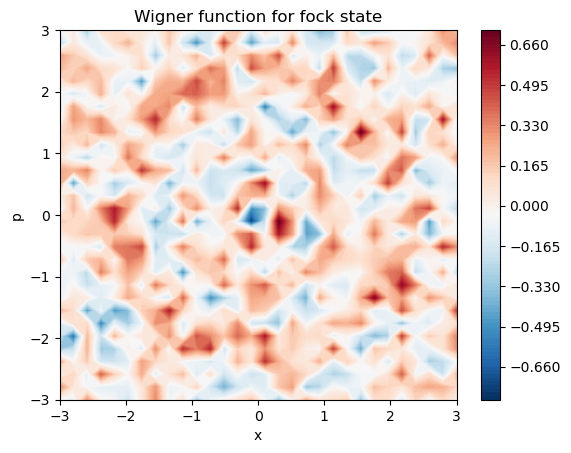

Optimal value: 21.804663576098122
Fidelity: 0.7739090509470669
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.01679 0.03462 0.01371 0.05501 0.02606 0.77391 0.02098 0.03307 0.0151
 0.01076]


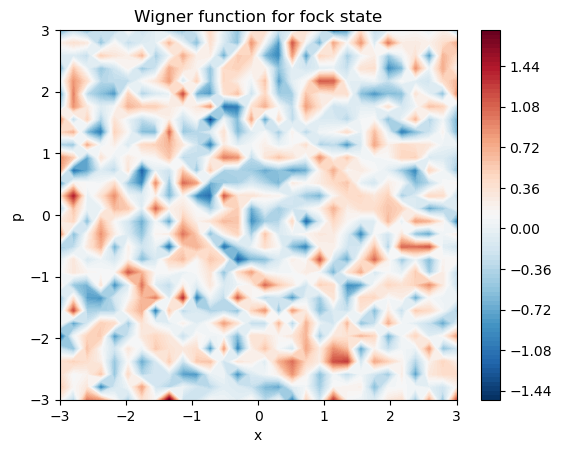

Optimal value: 133.54709685549705
Fidelity: 0.6092370031140079
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.00547 0.0257  0.14979 0.01357 0.01931 0.60924 0.0271  0.0764  0.03882
 0.03458]


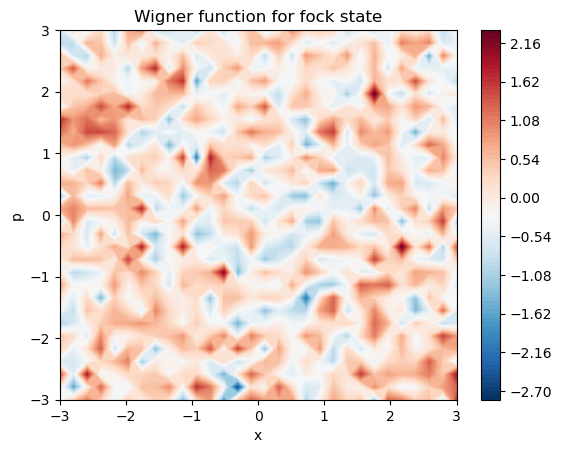

Optimal value: 266.46968346387325
Fidelity: 0.6462443181597942
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.00527 0.01565 0.02569 0.02129 0.05232 0.64624 0.07864 0.0593  0.04634
 0.04927]


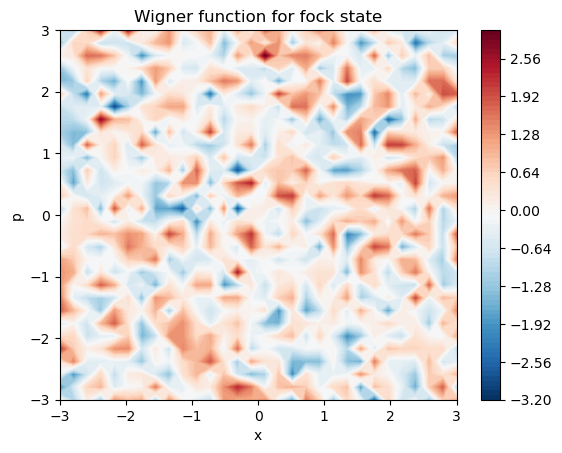

Optimal value: 517.2674069855144
Fidelity: 0.319162962272985
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.11321 0.05257 0.04551 0.07017 0.01946 0.31916 0.13001 0.03074 0.1188
 0.10037]


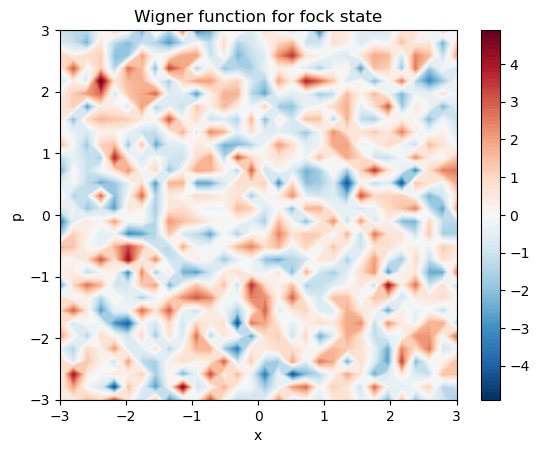

Optimal value: 1276.307576920507
Fidelity: 0.20918294673490662
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.06463 0.04632 0.02989 0.27754 0.12774 0.20918 0.0575  0.06195 0.02136
 0.1039 ]


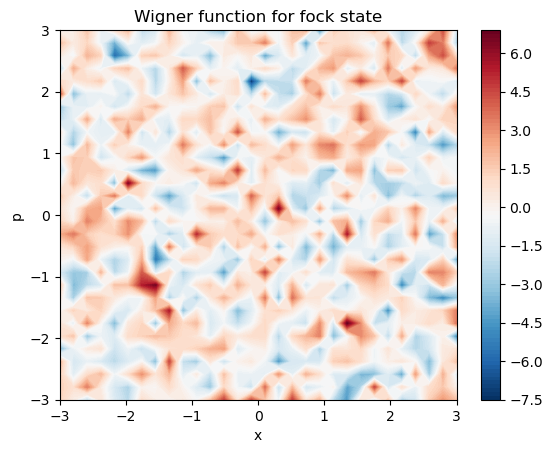

Optimal value: 2268.192950102408
Fidelity: 0.12528482014317566
True diag:         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Reconstructed diag: [0.04682 0.02998 0.03462 0.10512 0.10884 0.12528 0.18711 0.0301  0.0311
 0.30103]


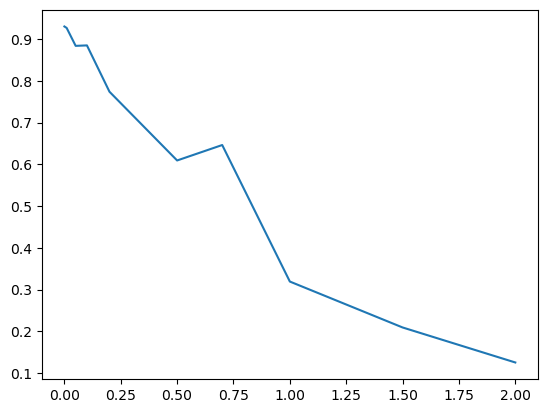

In [170]:
sigmas = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1, 1.5, 2]
fidelities_fock_noise = []

for sigma in sigmas:
    psi, rho_true, data = generate_psi(10, N, 'fock', 5, noise=True, sigma=sigma)
    fidelity_fock = fit_dm(data, rho_true, N, dim_ext=dim, dim=10)
    fidelities_fock_noise.append(fidelity_fock)
    
plt.plot(sigmas, fidelities_fock_noise, label='Fock state with noise')

(10, 10)


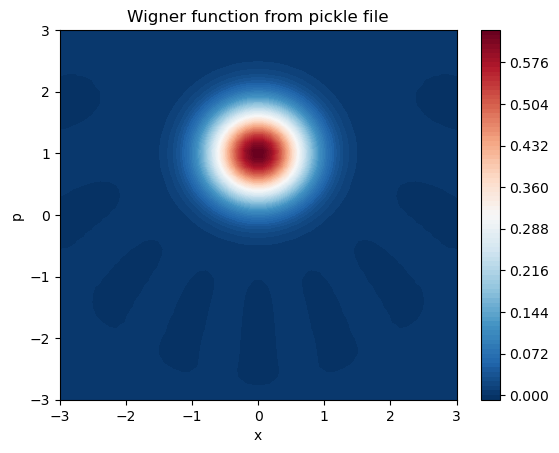

In [133]:
# Define the dimension of the Hilbert space and the Fock state number
dim = 10  # Hilbert space dimension
n =  9    # Fock state |n⟩

# Define x and p grids
x = jnp.linspace(-3, 3, 50)
p = jnp.linspace(-3, 3, 50)

# Create Fock state |n⟩
psi = dq.coherent(dim, alpha=1.0)
rho_true = dq.coherent_dm(dim, alpha=1.0)
print(rho_true.shape)

# Compute Wigner function
x, y, W = dq.wigner(psi, xvec=x, yvec=p)

plt.contourf(x, y, W, levels=100, cmap="RdBu_r")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("p")
plt.title("Wigner function from pickle file")
plt.show()

data = (x, y, W)

In [ ]:
def fit_dm(data, rho_true, N, dim):
    
    # Choose displacement points
    xmin, xmax = -3, 3
    ymin, ymax = -3, 3

    # Number of points per axis
    N = 50

    # Generate grid of (x, y) values
    x_vals = np.linspace(xmin, xmax, N)
    y_vals = np.linspace(ymin, ymax, N)

    # Create 2D grid of x and y values
    X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

    rho = cp.Variable((dim, dim), complex=True)
    #rho = 0.5 * (rho + rho.H)

    constraints = [
        rho >> 0,
        cp.trace(rho) == 1,
        rho == rho.H
    ]

    loss_expr = loss_cvxpy(rho, X, Y, data, dim=100, original_dim=dim)
    problem = cp.Problem(cp.Minimize(loss_expr), constraints)
    problem.solve(solver=cp.SCS)

    print("Optimal value:", problem.value)
    
    print("Fidelity:", fidelity(rho_true, rho.value))

    diag_true = np.real(np.diag(rho_true))
    diag_reco = np.real(np.diag(rho.value))

    # Print
    print("True diag:        ", np.round(diag_true, 5))
    print("Reconstructed diag:", np.round(diag_reco, 5))
    
    return fidelity(rho_true, rho.value)

In [134]:
# Choose displacement points
xmin, xmax = -3, 3
ymin, ymax = -3, 3

# Number of points per axis
N = 50

# Generate grid of (x, y) values
x_vals = np.linspace(xmin, xmax, N)
y_vals = np.linspace(ymin, ymax, N)

# Create 2D grid of x and y values
X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

rho = cp.Variable((dim, dim), complex=True)
#rho = 0.5 * (rho + rho.H)

constraints = [
    rho >> 0,
    cp.trace(rho) == 1,
    rho == rho.H
]

loss_expr = loss_cvxpy(rho, X, Y, data, dim=100, original_dim=dim)
problem = cp.Problem(cp.Minimize(loss_expr), constraints)
problem.solve(solver=cp.SCS)

print("Optimal value:", problem.value)

C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\1572478672.py:12: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))
c:\Users\ZenBook\miniconda3\envs\alicebobhack\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
c:\Users\ZenBook\miniconda3\envs\alicebobhack\Lib\site-packages\cvxpy\problems\problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


Optimal value: 1.9061990236819443e-09


In [135]:
print("Fidelity:", fidelity(rho_true, rho.value))

diag_true = np.real(np.diag(rho_true))
diag_reco = np.real(np.diag(rho.value))

# Print
print("True diag:        ", np.round(diag_true, 5))
print("Reconstructed diag:", np.round(diag_reco, 5))

Fidelity: 0.9999895513767477
True diag:         [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]
Reconstructed diag: [3.6788e-01 3.6788e-01 1.8394e-01 6.1310e-02 1.5330e-02 3.0700e-03
 5.1000e-04 7.0000e-05 1.0000e-05 0.0000e+00]


In [34]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# 1. Define analytical Wigner function of vacuum
def true_wigner(x, y):
    return (2 / np.pi) * np.exp(-2 * (x**2 + y**2))

# 2. Create grid
xvec = np.linspace(-5, 5, 100)
yvec = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(xvec, yvec, indexing='ij')
W = true_wigner(X, Y)

# 3. Your functions
def wigner_fct(x, y, data):
    xvec, yvec, W = data
    interp = RegularGridInterpolator((xvec, yvec), W, bounds_error=False, fill_value=0.0)
    return float(interp([[x, y]]))

def pk(x, y, data):
    return 0.5 * (1 + (np.pi / 2) * wigner_fct(x, y, data))

# 4. Test it
data = (xvec, yvec, W)
x_test, y_test = 0.5, -0.3

W_exact = true_wigner(x_test, y_test)
W_interp = wigner_fct(x_test, y_test, data)
pk_expected = 0.5 * (1 + (np.pi / 2) * W_exact)
pk_actual = pk(x_test, y_test, data)

print(f"W exact     = {W_exact:.6f}")
print(f"W interpol  = {W_interp:.6f}")
print(f"p_k exact   = {pk_expected:.6f}")
print(f"p_k computed= {pk_actual:.6f}")


W exact     = 0.322522
W interpol  = 0.321504
p_k exact   = 0.753308
p_k computed= 0.752509


C:\Users\ZenBook\AppData\Local\Temp\ipykernel_9476\3031829603.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(interp([[x, y]]))
